In [1]:
import warnings

import h5py
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

warnings.filterwarnings("ignore")

## Read the dataset from file and create a xarray dataset:

We read the original dataset and convert it to xarray using the code provided by the author:

In [2]:
def h5read(fname, vnames):
    with h5py.File(fname, "r") as f:
        variables = [f[v][()] for v in vnames]

        return variables if len(vnames) > 1 else variables[0]

In [3]:
fname = '/home/Raphael.Dussin/Olga/ice_shelf_melt.h5'

In [4]:
vnames = [
    "x",
    "y",
    "t",
    "melt_rate",
    "mask_boundaries",
    "mask_buffer_coastline",
    # "mask_buffer_floating",  # to buffer the GLs
]

(x, y, t, melt, mask, buff) = h5read(fname, vnames)

In [5]:
# Create xarray
ds = xr.Dataset({"melt": (("y", "x", "t"), melt),
                "mask": (("y", "x"), mask),
                "buffer": (("y", "x"), buff)},
                coords={"y": y,"x": x, "t": t})

ds = ds.transpose(*('t','y','x'))

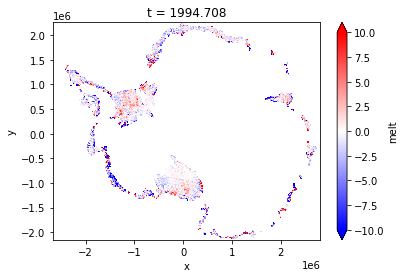

In [6]:
ds['melt'].isel(t=10).plot(vmin=-10, vmax=10,
                           cmap='bwr')

## Add geographical coordinates:

The original dataset has coordinates in a polar stereographic CRS so we need to add longitude/latitude.

**We need to confirm this is the right projection to use:**

In [7]:
PROJSTRING="+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

In [8]:
def add_lon_lat(ds, PROJSTRING, x='x', y='y', chunks={}):
    """ add longitude and latitude as compute from the inverse projection
    given in PROJSTRING
    
    PARAMETERS:
    -----------
    ds: xarray.Dataset
    
    PROJSTRING: str
    
    """
    from pyproj import CRS, Transformer
    # create the coordinate reference system
    crs = CRS.from_proj4(PROJSTRING)
    # create the projection from lon/lat to x/y
    proj = Transformer.from_crs(crs.geodetic_crs, crs)
    # make x,y 2d arrays
    xx, yy = np.meshgrid(ds[x].values, ds[y].values)
    # compute the lon/lat
    lon, lat = proj.transform(xx, yy, direction='INVERSE')
    # add to dataset
    ds['lon'] = xr.DataArray(data=lon, dims=('y', 'x'))
    ds['lat'] = xr.DataArray(data=lat, dims=('y', 'x'))
    
    ds = ds.assign_coords({'lon': ds['lon'],
                           'lat': ds['lat']})
    return ds

In [9]:
ds = add_lon_lat(ds, PROJSTRING)

In [10]:
# filter cells for all antarctica and buffer != (1,2,3)

ds['melt_flt'] = ds['melt'].where(ds.mask != -9999).where((ds.buffer != 3) &
                                                          (ds.buffer != 2) &
                                                          (ds.buffer != 1))

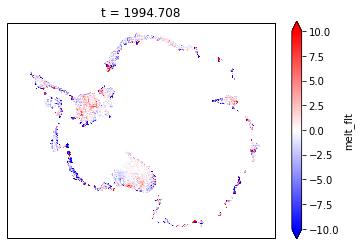

In [11]:
ds['melt_flt'].isel(t=10).plot(vmin=-10, vmax=10, cmap='bwr',
                               x='lon', y='lat',
                               subplot_kws={'projection': ccrs.SouthPolarStereo()},
                               transform=ccrs.PlateCarree())

Interpolate NaNs in the timeseries

In [12]:
ds['melt_flt'] = ds['melt_flt'].interpolate_na(dim="t")

## Load the model's grid and subset it:

In [13]:
datasetdir = '/archive/Raphael.Dussin/datasets/'
dirgrid = f'{datasetdir}/OM4p125/OM4p125_grid_20190404_blackseaFix_unpacked/'
hgrid = f'{dirgrid}/ocean_hgrid.nc'
mask = f'{dirgrid}/ocean_mask.nc'

In [14]:
supergrid = xr.open_dataset(hgrid)
dsmask = xr.open_dataset(mask)

Create a southern ocean subgrid to speed up interpolation:

In [15]:
grid = xr.Dataset()

grid['lon'] = xr.DataArray(data=supergrid['x'].values[1:1000:2, 1::2],
                           dims=('y', 'x'))
grid['lat'] = xr.DataArray(data=supergrid['y'].values[1:1000:2, 1::2],
                           dims=('y', 'x'))

## Regrid the dataset:

The dataset is full of Nans so nearest neighbour interpolation always works but we could also fill nans with zeros and try a conservative method:

In [16]:
import xesmf

In [17]:
%%time

regrid = xesmf.Regridder(ds, grid, method='nearest_s2d', periodic=True)

(1452, 1836)
Overwrite existing file: nearest_s2d_1452x1836_500x2880_peri.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 1min 35s, sys: 945 ms, total: 1min 36s
Wall time: 1min 36s


In [18]:
%%time

melt_regrid = regrid(ds['melt_flt'])

CPU times: user 4.66 s, sys: 321 ms, total: 4.98 s
Wall time: 4.98 s


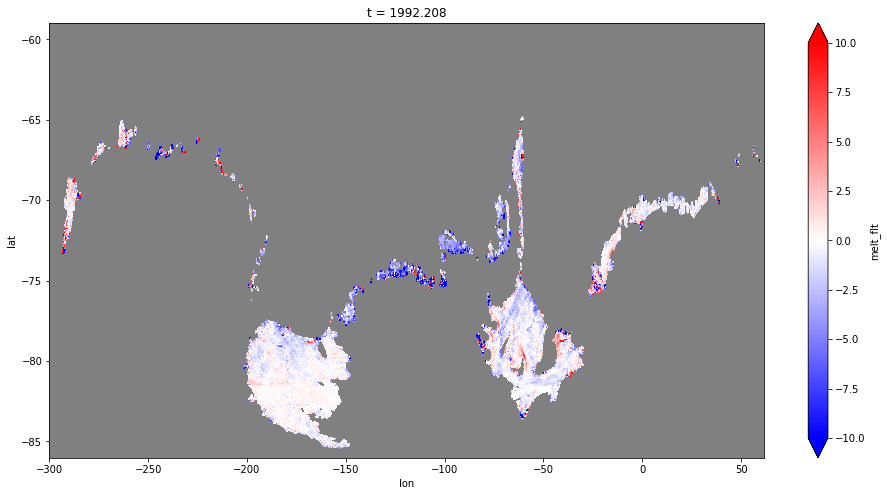

In [19]:
plt.figure(figsize=[16,8])

melt_regrid.isel(t=0).plot(x='lon', y='lat',
                           subplot_kws={'facecolor': 'grey'},
                           vmin=-10, vmax=10,
                           cmap='bwr')

## Extend to the full domain

first remove all nans:

In [20]:
melt_regrid = melt_regrid.fillna(0.)

then create an array full of zeros for everything north of the southern ocean subset:

In [21]:
zeros_north = xr.DataArray(data=np.zeros((104, 1740, 2880)), dims=('t','y', 'x'))
zeros_north['lon'] = xr.DataArray(supergrid['x'].values[1000:-1:2, 1::2], dims=('y', 'x'))
zeros_north['lat'] = xr.DataArray(supergrid['y'].values[1000:-1:2, 1::2], dims=('y', 'x'))
zeros_north['t'] = melt_regrid['t']

and concatenate:

In [22]:
melt_full_domain = xr.concat([melt_regrid, zeros_north], dim='y')

## Mask the final array:

NB: we need the mask with cavities

In [23]:
dsmask = dsmask.rename({'nx': 'x', 'ny': 'y'})

In [24]:
melt_masked = melt_full_domain.where(dsmask['mask'] == 1)

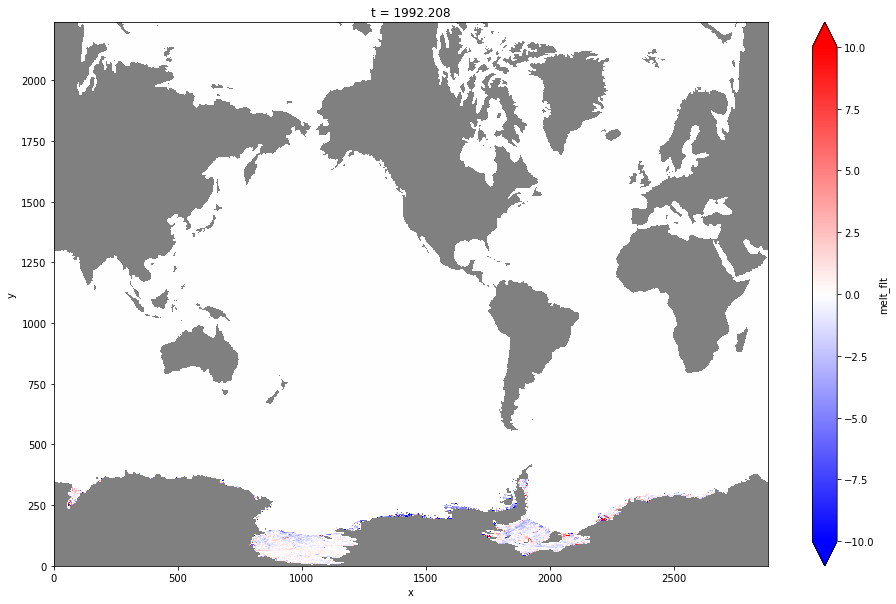

In [25]:
plt.figure(figsize=[16,10])
melt_masked.isel(t=0).plot(vmin=-10,vmax=10, cmap='bwr',
                           subplot_kws={'facecolor': 'grey'})

## Save the final file

In [27]:
outputdir = '/local2/home/OM4_125_bedmachine_ant1/iceshelves_melt'
ds = xr.Dataset()
ds['melt'] = melt_masked
ds.to_netcdf(f'{outputdir}/iceshelves_melt.nc', format='NETCDF3_64BIT')